In [73]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import requests, json, maxminddb, tqdm

# EDA

Здесь посмотрим на данные, которые лежат в выборке без аномалий и те, которые лежат в выборке с аномалиями. Посмотрим на колонки, которые уже распаршены, а именно 'addr', 'handshake', 'packets', 'port', 'proto'. Далее из колонки packets в ходе EDA буду выделять новые колонки.

Наша задача сейчас - верхнеуровнево понять, насколько то, что есть, будет полезно в ходе машинного обучения.
1. Как много пропусков
2. Нет ли статичных колонок

Лишнее удалим.

In [53]:
df_train = pd.DataFrame(columns = ['addr', 'packets', 'port', 'proto', 'handshake'])

response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources', 
                            {'public_key':'https://disk.yandex.ru/d/SRpp1XyYiXiZlg', 'limit':'100'})
for item in tqdm.tqdm(response.json()['_embedded']['items']):
    if item['name'].startswith('sessions_of_https'):
        json_file = requests.get(item['file'])
        json_content = json.loads(json_file.content)
        df_train=pd.concat([df_train, pd.DataFrame(json_content)], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [09:59<00:00, 10.00s/it]


In [54]:
df_train.head()

,addr,packets,port,proto,handshake
0,140.82.121.6,"[{'timestamp': 1698434896.269325}, {'timestamp...",443,tcp,[{'Extension: key_share (len=36)': {'Key Share...
1,172.64.41.4,"[{'timestamp': 1698434900.01603}, {'timestamp'...",443,tcp,[{'Extension: key_share (len=36)': {'Key Share...
2,34.160.144.191,"[{'timestamp': 1698434900.921825}, {'timestamp...",443,tcp,[{'Extension: application_layer_protocol_negot...
3,209.85.233.104,"[{'timestamp': 1698434901.770399}, {'timestamp...",443,tcp,[{'Extension: key_share (len=36)': {'Key Share...
4,209.85.233.94,"[{'timestamp': 1698434902.141365}, {'timestamp...",443,tcp,[{'Extension: key_share (len=36)': {'Key Share...


Смотрим на процент уникальных данных в колонках

In [55]:
round(df_train.addr.nunique() / df_train.shape[0] * 100, 2)

35.65

In [56]:
round(df_train.port.nunique() / df_train.shape[0] * 100, 2)

0.01

In [57]:
round(df_train.proto.nunique() / df_train.shape[0] * 100, 2)

0.01

In [58]:
round(len(df_train[df_train['handshake'].fillna(0) !=0]) / len(df_train) * 100, 2)

74.23

In [59]:
df_train.port.nunique()

1

In [60]:
df_train.proto.nunique()
# кажется, колонку proto вообще нужно дропнуть
# но посмотрим, что лежит в файлах с аномалиями

1

Планы:
1. Продолжу смотреть что в handshake

    1.1. Сделаю бинарную колонку с наличием и отсутствием рукопожатия
    
    1.2. Расшаршу ее глубже, посмотрю что с сертификатами

2. data - превратим в булево поле: есть нераскодированные данные или нет в этом соединении

3. 443, 4433, 80, 8080 это стандартные порты. 35600 - это нестандартный порт. Мы должны сохранить эту колонку

4. Идея представить addr как вектор. Четыре разные колонки с цифрами

    4.1. Вычислить по айпи месторасположение
5. Duration между timestamp'ами - считать среднее, медиану между ними
6. Дропнуть дубликаты
7. Сертификаты - самоподписной, их количество 

In [61]:
df_train['num_timestamps'] = pd.Series()
for i in range(0, len(df_train['packets'])):
    df_train['num_timestamps'][i] = str(df_train['packets'][i]).count('timestamp')

In [62]:
df_train['timestamps'] = pd.Series()
for i in range(0, len(df_train)):
    if df_train['num_timestamps'][i] != 0 and df_train['num_timestamps'][i] != 1:
        timestamps_list = []
        for j in range(0, len(df_train['packets'][i])):
            timestamps_list.append(df_train['packets'][i][j]['timestamp'])
        df_train['timestamps'][i] = str(timestamps_list)

In [63]:
len(df_train)

17841

In [64]:
df_train['mean_timestamps'] = pd.Series() 
df_train['median_timestamps'] = pd.Series() 
for i in range(0, len(df_train)): 
    if df_train['num_timestamps'][i] != 0 and df_train['num_timestamps'][i] != 1: 
        temp = [] 
        str_timestamps = df_train['timestamps'][i] 
        str_timestamps = str_timestamps[1:-1] 
        list_of_timestamps = list(str_timestamps.split(",")) 
        if len(list_of_timestamps) != df_train['num_timestamps'][i]: print(f'Разное кол-во таймстемпов на строке {i}') 
        for j in range(0, len(list_of_timestamps)-1): 
            if j == int(df_train['num_timestamps'][i])-1: continue 
            raznica = float(list_of_timestamps[j+1]) -  float(list_of_timestamps[j]) 
            temp.append(raznica) 
        df_train['mean_timestamps'][i] = np.mean(temp) 
        df_train['median_timestamps'][i] = np.median(temp)

Разное кол-во таймстемпов на строке 61
Разное кол-во таймстемпов на строке 63
Разное кол-во таймстемпов на строке 87
Разное кол-во таймстемпов на строке 231
Разное кол-во таймстемпов на строке 344
Разное кол-во таймстемпов на строке 453
Разное кол-во таймстемпов на строке 562
Разное кол-во таймстемпов на строке 594
Разное кол-во таймстемпов на строке 680
Разное кол-во таймстемпов на строке 1015
Разное кол-во таймстемпов на строке 1113
Разное кол-во таймстемпов на строке 2106
Разное кол-во таймстемпов на строке 2112
Разное кол-во таймстемпов на строке 2215
Разное кол-во таймстемпов на строке 2246
Разное кол-во таймстемпов на строке 2253
Разное кол-во таймстемпов на строке 2360
Разное кол-во таймстемпов на строке 2404
Разное кол-во таймстемпов на строке 2427
Разное кол-во таймстемпов на строке 2436
Разное кол-во таймстемпов на строке 2453
Разное кол-во таймстемпов на строке 2478
Разное кол-во таймстемпов на строке 2503
Разное кол-во таймстемпов на строке 2605
Разное кол-во таймстемпов на

### Посмотрим на данные с аномалиями

In [65]:
df_train_anomaly = pd.DataFrame(columns = ['addr', 'packets', 'port', 'proto', 'handshake'])

response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources', 
                            {'public_key':'https://disk.yandex.ru/d/SRpp1XyYiXiZlg', 'limit':'100'})
for item in tqdm.tqdm(response.json()['_embedded']['items']):
    if item['name'].startswith('sessions_of_2023'):
        json_file = requests.get(item['file'])
        json_content = json.loads(json_file.content)
        df_train_anomaly=pd.concat([df_train_anomaly, pd.DataFrame(json_content)], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.72it/s]


In [66]:
df_train_anomaly.head()

,addr,packets,port,proto,handshake
0,192.168.1.1,"[{'timestamp': 1672959060.238688}, {'timestamp...",53,udp,NaN
1,45.56.99.101,"[{'timestamp': 1672959060.317084}, {'timestamp...",80,tcp,NaN
2,64.185.227.156,"[{'timestamp': 1672959086.063915}, {'timestamp...",443,tcp,[{'Extension: ec_point_formats (len=2)': {'ext...
3,204.11.58.28,"[{'timestamp': 1672959089.67526}, {'timestamp'...",587,tcp,NaN
4,40.126.29.10,"[{'timestamp': 1672959334.359111}, {'timestamp...",443,tcp,[[{'Extension: extended_master_secret (len=0)'...


In [67]:
df_train_anomaly.addr.nunique()

362

In [68]:
df_train_anomaly.port.nunique()

814

In [69]:
df_train_anomaly.proto.nunique()

3

In [70]:
df_train_anomaly['num_timestamps'] = pd.Series()
for i in range(0, len(df_train_anomaly['packets'])):
    df_train_anomaly['num_timestamps'][i] = str(df_train_anomaly['packets'][i]).count('timestamp')

In [71]:
df_train_anomaly['timestamps'] = pd.Series()
for i in range(0, len(df_train_anomaly)):
    if df_train_anomaly['num_timestamps'][i] != 0 and df_train_anomaly['num_timestamps'][i] != 1:
        timestamps_list = []
        for j in range(0, len(df_train_anomaly['packets'][i])):
            timestamps_list.append(df_train_anomaly['packets'][i][j]['timestamp'])
        df_train_anomaly['timestamps'][i] = str(timestamps_list)

In [74]:
df_train_anomaly['mean_timestamps'] = pd.Series() 
df_train_anomaly['median_timestamps'] = pd.Series() 
for i in range(0, len(df_train_anomaly)): 
    if df_train_anomaly['num_timestamps'][i] != 0 and df_train_anomaly['num_timestamps'][i] != 1: 
        temp = [] 
        str_timestamps = df_train_anomaly['timestamps'][i] 
        str_timestamps = str_timestamps[1:-1] 
        list_of_timestamps = list(str_timestamps.split(",")) 
        if len(list_of_timestamps) != df_train_anomaly['num_timestamps'][i]: print(f'Разное кол-во таймстемпов на строке {i}') 
        for j in range(0, len(list_of_timestamps)-1): 
            if j == int(df_train['num_timestamps'][i])-1: continue 
            raznica = float(list_of_timestamps[j+1]) -  float(list_of_timestamps[j]) 
            temp.append(raznica) 
        df_train_anomaly['mean_timestamps'][i] = np.mean(temp) 
        df_train_anomaly['median_timestamps'][i] = np.median(temp)

In [131]:
df_train['anomaly'] = 0
df_train_anomaly['anomaly'] = 1
# генерирую колонку ответов

In [132]:
df = pd.concat([df_train, df_train_anomaly])
# генерирую общий датафрейм

In [133]:
df['mean_timestamps'] = df['mean_timestamps'].map(lambda x: pd.to_timedelta(x).microseconds)
df['median_timestamps'] = df['median_timestamps'].map(lambda x: pd.to_timedelta(x).microseconds)
# для удобства перевожу в инт

Сравним между собой данные с аномалиями и данные с отсутствием аномалий. Если найдем колонки, не имеющие разницы, они станут кандидатами на удаление. В первую очередь посмотримна сгенерированные нами колонки.

In [140]:
df.reset_index(inplace=True)

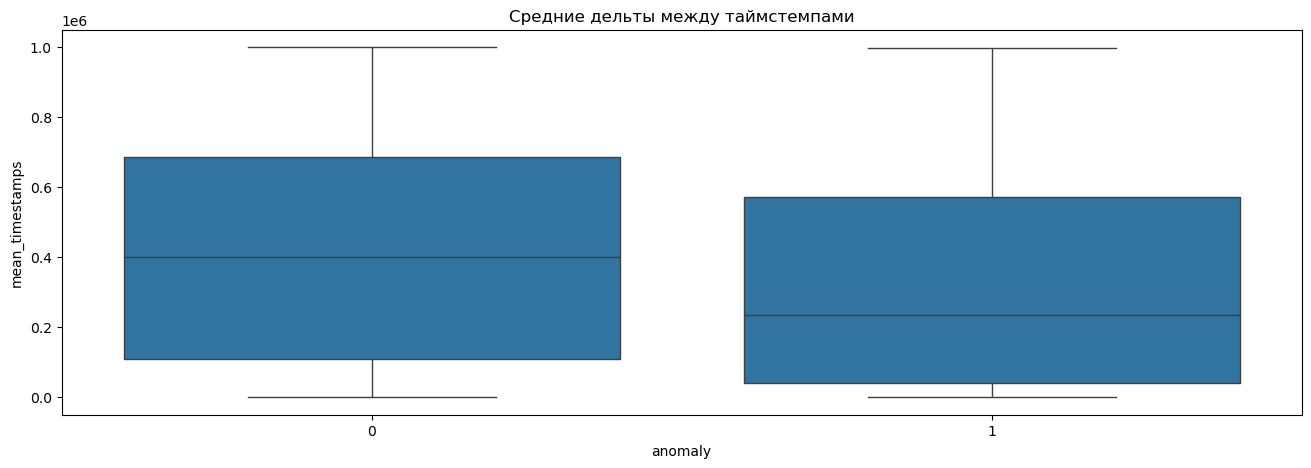

In [141]:
fig, axs = plt.subplots(1)
fig.set_size_inches(16, 5)

sns.boxplot(data=df, x = 'anomaly', y = 'mean_timestamps').set_title("Средние дельты между таймстемпами")

plt.xticks(rotation=0)
plt.show()

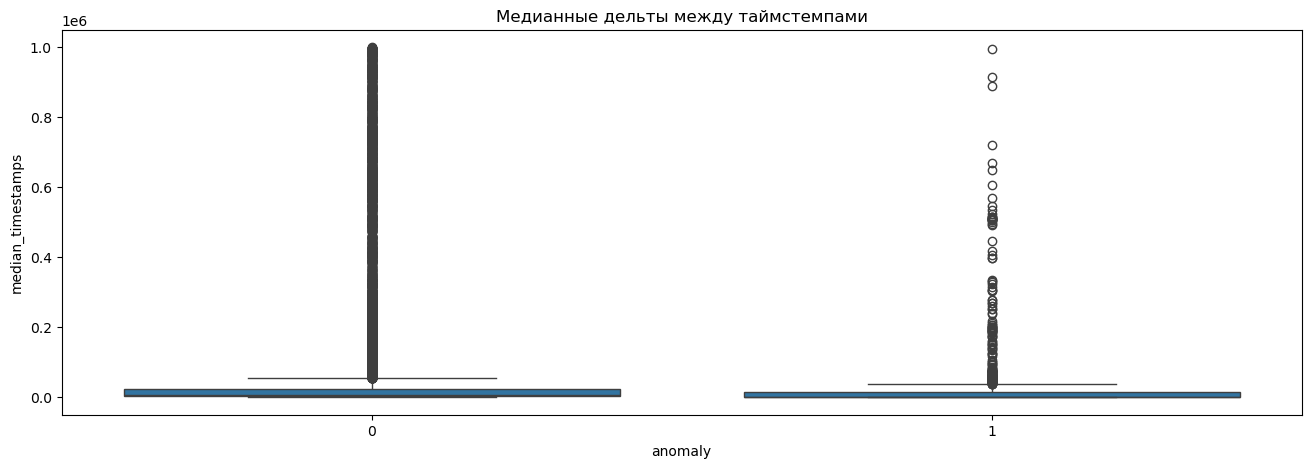

In [142]:
fig, axs = plt.subplots(1)
fig.set_size_inches(16, 5)

sns.boxplot(data=df, x = 'anomaly', y = 'median_timestamps').set_title("Медианные дельты между таймстемпами")

plt.xticks(rotation=0)
plt.show()

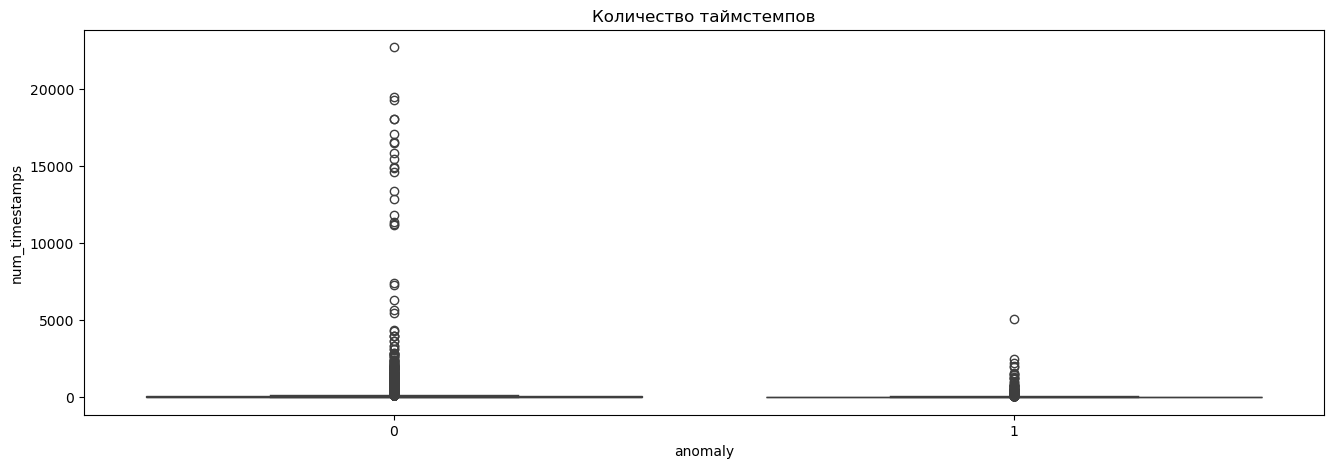

In [143]:
fig, axs = plt.subplots(1)
fig.set_size_inches(16, 5)

sns.boxplot(data=df, x = 'anomaly', y = 'num_timestamps').set_title("Количество таймстемпов")

plt.xticks(rotation=0)
plt.show()

Посмотрим, есть ли различия между портами, их количеством в группировке по классам

In [144]:
df.groupby(['anomaly'], as_index=False).port.nunique()

,anomaly,port
0,0,1
1,1,814


Посмотрим, есть ли различия между proto, их количеством в группировке по классам

In [145]:
df.groupby(['anomaly'], as_index=False).proto.nunique()

,anomaly,proto
0,0,1
1,1,3


Пока кажется, что каждую из фичей 'port', 'proto', 'num_timestamps', 'mean_timestamps', 'median_timestamps' нужно оставить. Попробуем сгененрировать фичи из колонки 'addr': найдем страну.

In [160]:
addr_to_country = dict()

with maxminddb.Reader('./mmdb/GeoLite2-Country.mmdb') as reader:
    response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources', {'public_key':'https://disk.yandex.ru/d/SRpp1XyYiXiZlg', 'limit':'100'})
    for item in tqdm.tqdm(response.json()['_embedded']['items']):
        if item['name'].startswith('nodes_of'):
            continue
        json_file = requests.get(item['file'])
        json_content = json.loads(json_file.content)
        for sess in json_content:
            if sess['addr'] in addr_to_country: continue
            res = reader.get(sess['addr'])
            if res is None: continue
            addr_to_country[sess['addr']] = res['registered_country']['names']['en']

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [11:40<00:00, 11.67s/it]


In [172]:
cntr = []
for i in df['addr']:
    if i in list(addr_to_country.keys()):
        cntr.append(addr_to_country[i])
    else:
        cntr.append('unknown_country')
df['country'] = cntr

In [176]:
len(df[df['country'] == 'unknown_country']) / len(df)
# всего 5 процентов стран потеряно

0.046372867162148015

In [177]:
df.groupby(['anomaly'], as_index=False).country.nunique()
# очевидны отличия между классами

,anomaly,country
0,0,38
1,1,28


In [178]:
df[['addr', 'port', 'proto', 'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly']].shape

(19106, 7)

In [179]:
df[['addr', 'port', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly']].drop_duplicates().shape

(19085, 7)

Так как генерировали много признаков из одной колонки, посмотрим на корреляции

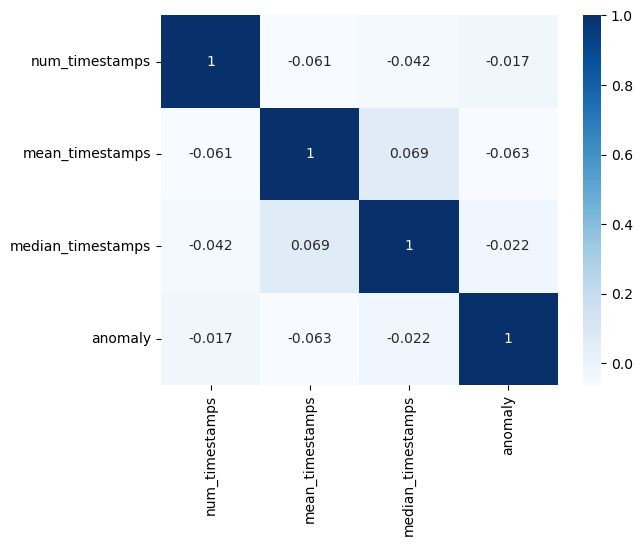

In [180]:
sns.heatmap(df[['addr', 'port', 'proto',
               'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly']].drop_duplicates().corr(), 
            cmap="Blues", annot=True);

In [181]:
df.to_csv('data.csv')

# Pipeline

## Итерация 1

Обучим на этих фичах модель. Для первого подхода выбрала catboost. 

Затем замерим качество на отложенной выборке, посмотрим, какие фичи наиболее важны.

In [182]:
X = df[['addr', 'port', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

y = X['anomaly']
X = X.drop(['anomaly'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [183]:
!pip install catboost
from catboost import CatBoostClassifier

clf = CatBoostClassifier(random_state=42, verbose=False,
                        cat_features = ['addr', 'port', 'proto', 'country'])

In [184]:
model_1 = clf.fit(Xtrain, ytrain)

In [185]:
sum(model_1.predict(Xtest) ==1)
# какие-то все же пометил аномалиями
# отлично, посчитаем roc_auc_score

327

In [186]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

round(roc_auc_score(ytest, model_1.predict(Xtest)), 2)
# для сравнения с другими моделями

0.92

In [187]:
round(f1_score(ytest, model_1.predict(Xtest)), 2)
# для оценки работы модели

0.9

In [188]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model AUC score: 0.9194896490233679


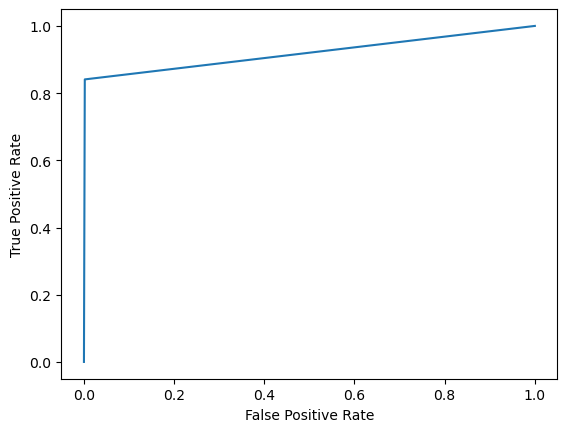

In [189]:
plot_roc_curve(ytest, model_1.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model_1.predict(Xtest))}')

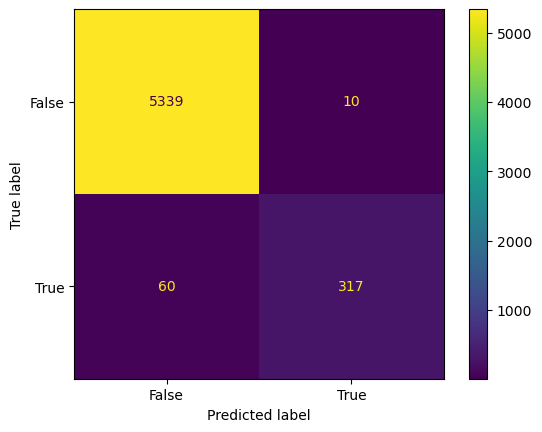

In [190]:
confusion_matrix = confusion_matrix(ytest, model_1.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

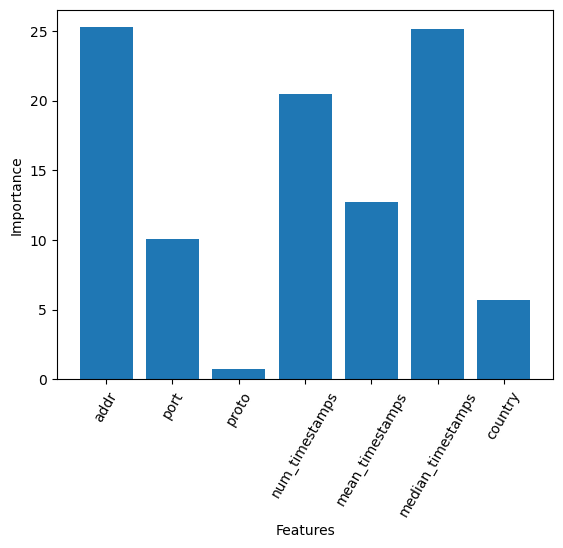

In [191]:
plt.bar(Xtrain.columns, model_1.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show

## Промежуточные итоги

Очень похоже, что модель переобучилась под наши данные, и из-за их количества мы не увидели это на тесте. Попробуем проверить эту гипотезу, начнем с исследования порта. Сколько правильных ответов, когда порт 443 и когда это аномалия?

In [192]:
Xtest['predict'] = model_1.predict(Xtest)
Xtest['ans'] = ytest
len(Xtest[(Xtest['port'] == '443') & (Xtest['ans'] == 1) & (Xtest['predict'] == 1)])

36

А сколько неверно?

In [193]:
len(Xtest[(Xtest['port'] == '443') & (Xtest['ans'] == 1) & (Xtest['predict'] == 0)])

60

То есть примерно в значительной части случаев модель ошиблась на 443 порте. На неаномалиях этот порт единственный. Попробуем просто выкинуть эту фичу, похоже, что модель под нее переобучилась.

Продолжим с колонкой айпи-адреса. Среди вредных адресов встречается ли один какой-то?

In [195]:
Xtest[(Xtest['ans'] == 1)].value_counts('addr')[0:5]

addr
10.4.19.138       222
10.4.19.143        22
10.4.19.19          3
10.7.10.9           3
52.137.106.217      2
dtype: int64

In [196]:
len(Xtest[(Xtest['ans'] == 1) & (Xtest['addr'] == '10.4.19.138') & (Xtest['predict'] == 1)]) / 225

0.9866666666666667

Почти в ста процентах случаев с первым адресом модель угадала правильный ответ. Явно присутствует переобученность и на этой колонке:

1. Кажется, строки с первым адресом стоит выкинуть. 

2. И от самих адресов оставим также первые две цифры.

## Итерация 2

Выкинем фичу порт и из адреса сделаем две новые фичи. Посмотрим, как измерится качество модели.

In [197]:
X = df[['addr', 'proto', 'num_timestamps', 'mean_timestamps', 
    'median_timestamps', 'anomaly', 'country']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']
X = X.merge(pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4']), left_index=True, right_index=True)

y = X['anomaly']
X = X.drop(['anomaly', 'addr_3', 'addr_4', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [198]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        cat_features = ['addr_1', 'addr_2', 'proto', 'country'])

In [199]:
model = clf.fit(Xtrain, ytrain)

In [200]:
sum(model.predict(Xtest) ==1)
# какие-то все же пометил аномалиями
# отлично, посчитаем roc_auc_score

67

In [201]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

round(roc_auc_score(ytest, model.predict(Xtest)), 2)
# для сравнения с другими моделями

0.81

In [202]:
round(f1_score(ytest, model.predict(Xtest)), 2)
# для оценки работы модели

0.74

model AUC score: 0.8095327976079238


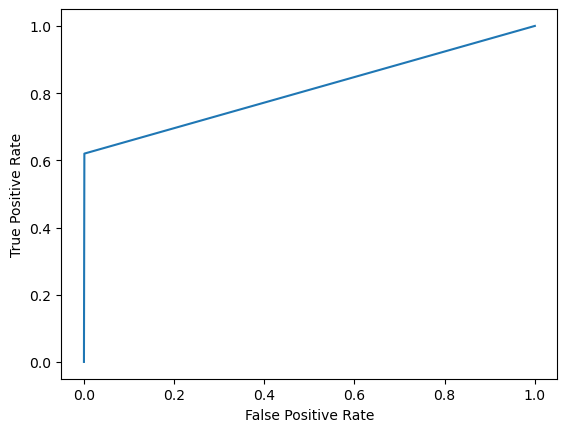

In [203]:
plot_roc_curve(ytest, model.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model.predict(Xtest))}')

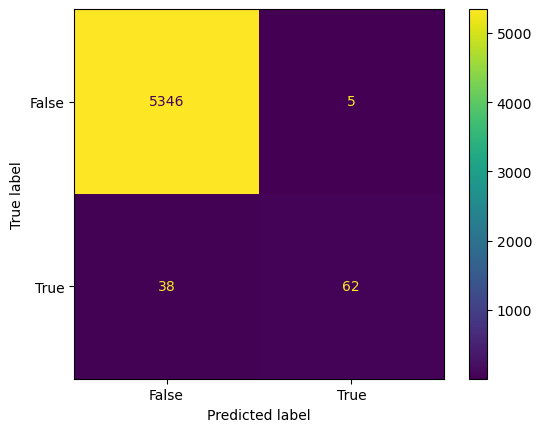

In [204]:
confusion_matrix = confusion_matrix(ytest, model.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

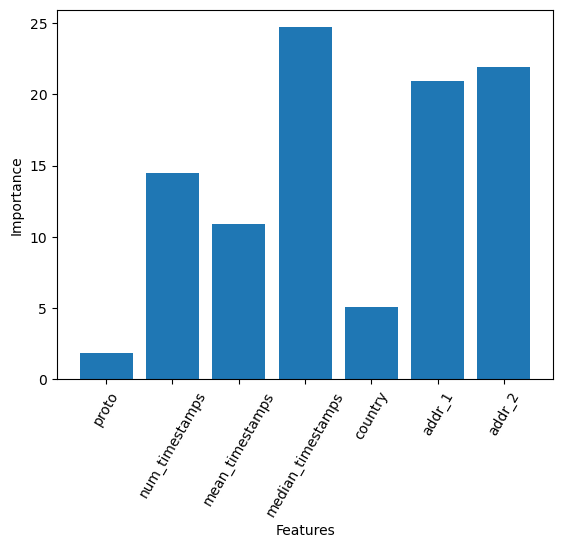

In [205]:
plt.bar(Xtrain.columns, model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.show

# Итого,

по результатам EDA выделила 7 фичей, из них 4 - качественные: addr, port, proto, country. 3 количественные фичи (num_timestamps, mean_timestamps, median_timestamps) сгенерированы из таймстемпов. Корреляция между этими фичами почти отсутствует, поэтому все из них взяла в модель.

Обучила катбуст, оценка на тесте - 0.94. Выявили переобученность модели под две фичи и провели еще одну итерацию обучения модели. на новых фичах: убрали порт, часть записей с одним и тем же адресом и от самого адреса оставили первые две цифры. Качество модели драматически упало до 0.74.

Цель последующей работы - дотянуть roc_auc_score до 0.9. Что будем делать:

1. Генерировать и тестировать новые фичи

    1.1. Возможно, сравним результат также с другой моделью
    

2. Обучим нейронную сеть

Recall в данной задаче нам важнее. Важно не пустить пользователя на вредоносный сайт, но при этом нужно понимать, что иногда мы можем не пустить его и на нормальный сайт. В данном случае высока цена ошибки будет высока. Финальный датафрейм выглядит так: